# This is the template for coursework B - Add a suitable title

<div class="alert alert-block alert-danger">
<b>Candidate number: Your candidate number here (this is a five digit number). </b>

- This Coursework contributes <b>80%</b> to your overall unit mark.

- Will be marked anonymously.

- Keep to word limits (+- a few words).

- You can use the WordCounter notebook to check your word count.

- Code & figure captions do not count towards word limits.
</div>

### Abstract: 

Here, give an overview of your work, make sure to describe the science background, methods, results as well as comparisons to literature data. Keep this short.
<div class="alert alert-block alert-danger">
    
<b>word limit 250 words.</b>

Possible habitable exoplanets have been discovered orbiting bright stellar hosts in the TESS and Kepler Exoplanet surveys. To analyze exoplanet habitability, the most important factors are accurate estimates of their orbital eccentricity, the presence of liquid surface water, and the planetary mass and radius 
In this work, we identify two exoplanets from Kepler transit data, finding their radii to be $(8.27+-1.3)_{earth}$ and $(7.49+-3.5)_{earth}$ respectively by fitting polynomials to their folded lightcurve.

For the planet with found period $(19.22+-0.97)_{days}$, an in-depth habitability analysis is conducted using a Markov chain Monte-Carlo simulation. Using the mean flux approximation, the planet is found to receive on average $(69.4+-9.6)$ KWatts m^-2, corresponding to no liquid water at its surface. The planetary radius and mass were found to be $(7.49 +- 3.52)_{earth radii}$ and $(29.1)_{earth mass}$ respectively, corresponding to a gravitational field inhospitable for human life, but the potential for a gaseous atmosphere. 

Finally, The stellar density of exoplanet 2 was found to be $(1.41)_{sun}$, however, this is found to be highly degenerate with the found impact parameter of $0.51$. Better characterization of this problem to allow for accurate eccentricity modeling is discussed for future work. 

#### Imports: give all your imports in a box here. Any custom code you have stored in a .py file needs to be submitted with your coursework. You can freely use all code provided to you as part of this course. If you use code not encountered in the course, give a link to the online repo.

In [414]:
#Data handling
import numpy as np
import pandas as pd 
from astropy.io import fits #used to open fits files in which data are stored
import glob
import os 

#Signal processing imports

from scipy.signal import savgol_filter, lombscargle
from scipy.optimize import curve_fit
import scipy 

#Modelling imports 
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import pymc3_ext as pmx

#Visualization imports 
import arviz as az
import corner
import matplotlib.pyplot as plt
import seaborn as sns

#Progress bars
import tqdm
from typing import Optional

#Utils file 
from utils import * 

import arviz as az
az.style.use("arviz-darkgrid")


In [415]:
#Filter warnings for ignore level, this isn't always a good idea but theano warnings are very verbose.
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-danger">
<b>Make sure to include the relevant python files in your upload</b>

### 1. Introduction:

Give an introduction to your coursework. This should be a short description of exoplanets as well as a description of background relevant to your Discussion.

Your introduction should be understandable to a student having taken Intro to astro and Planets & Exoplanets. 

<div class="alert alert-block alert-danger">
<b>Word limit: 600 words</b>

A central problem in astronomy is the search for other planets bearing life.
In recent years TESS (Ricker et Al. 2018) surveys have discovered thousands of confirmed exoplanets orbiting a range of stellar hosts. Of these confirmed transits indicating an exoplanet orbiting a star, only a small subset of these bodies are candidates for hosting life. There has consequently been a large body of research (Yadev 2018) on generating likely candidates for habitable exoplanets from large-scale sky surveys such as TESS or Kepler.



Indicators for habitability come from a range of sources; from time series data of the stellar flux of a star, we can detect exoplanets by periodic drops in flux. These troughs, coined 'transits' by astronomers, are caused by the partial occlusion of the view of a star from an observation telescope.

After confirming the presence of an exoplanet, astronomical spectrometry and radial velocity can be used to find the exoplanet's mass, atmospheric composition, and temperature as the key indicators of suitability for life.

Before justifying this extra analysis and instrument time however, we can look at the transit curves to derive the mass ratio of the host star and exoplanet and the orbit's semi-major axis.


Additionally, habitability analysis requires high accuracy measurement of planetary period and radius. Stellar and transit parameters allows researchers to further ensure confidence in their astrophysical model. Parameters of interest are the stellar limb darkening (the extent to which the central part of the star 'disk' seems brighter than its edges) and the impact parameter (the verticle elevation distance between the center of the star and the exoplanet as defined below)

$$ b = \frac{a cos(i)}{R_{*}}$$


Often the extent to which a given exoplanet's orbit deviates from being circular, its eccentricity, is also considered a prominent factor in habitability, such as in analysis by Williams and Kasting (1997).

Striving to be confident in their results for exoplanet measurements, instead of expressing these quantities as scalars, many astronomers choose to treat transit light curve data as a stochastic time series. Researchers can obtain probabilistic estimates of the parameters characterizing these transits using gaussian processes or Markov-chain Monte Carlo (MCMC) simulations. These models yield bayesian estimates for their parameters, allowing for rigorous considerations of parameter error, confidence, and covariance.


In this work, we will perform an in-depth analysis of a reading of stellar flux from the Kepler telescope to confirm the existence of two orbiting exoplanets. Using various periodograms, we will derive estimates of the number of exoplanets in the stellar system and their respective orbital periods. After this, we will find their mass ratio and average transit length, taking an average over a series of transits.


Additionally, for the body with the shorter period, more rigorous analysis will be applied. We will perform a MCMC simulation of keplerian orbit model on the exoplanets folded light curve. From this model, we will generate estimates of the posterior distribution for stellar properties, orbital parameters, and transit jitter. This will allow us to describe the properties of the exoplanet, and by extension, its suitability for hosting life. Following this, we will perform statistical analysis on the goodness of fit of the transit light curve for all found exoplanets, and any correlations in model parameters that may affect our predictions.

### 2. Results - Modelling of Kepler lightcurve

$\bullet$ describe fitting of transit depths and present results with errors

$\bullet$ describe periodogram and identification of periodic features in lightcurves

$\bullet$ describe motivation for any additional fitting you have done

$\bullet$ include code for all modelling in attached code or inline, describe limitations and assumptions made

<div class="alert alert-block alert-danger">
    
<b>Keep this concise: word limit 750 words</b>

In [416]:
mykepler = '1'

<h2>Data Parsing</h2>	


To find a transit where there has been a noticable drop in the flux as a function of time, first we must load the data in and handle it effectively. 

Each of the 17 data subsects has a different magnitude of flux; for analysis of the light curve we want a 'smooth' time series without large scale 
step jumps. To get this, we normalize the flux and flux by dividing by the sample mean of the flux. 

We want to increase our signal precision by smoothing it, taking care not to distort its tendancy. To do this we use a Savitzky–Golay filter which 
fits a low order polynomial to data subsamples of a specific sample size which can be combined to find a smoothed signal.

In [417]:
#Get arrays for the flux so that we can do further analysis 
savgol_filter_window_size = 271
savgol_filter_poly_order = 3
total_flux, total_time, total_flux_error = [], [], []

for lcfile in tqdm.tqdm(glob.glob('Data/Object%slc/kplr*.fits' %(mykepler))):
    tmp = fits.open(lcfile)
    tmptime = (tmp[1].data['TIME'])
    tmpflux = (tmp[1].data['PDCSAP_FLUX'])
    tmperror = (tmp[1].data['PDCSAP_FLUX_ERR'])
    
    #Remove Nans for flux and flux error 
    tmpflux_mask, tmperror_mask  = np.isfinite(tmpflux), np.isfinite(tmperror)
    total_mask = np.logical_and(tmpflux_mask, tmperror_mask)
    time_sample, flux_sample, flux_sample_error = tmptime[total_mask], tmpflux[total_mask], tmperror[total_mask]

    #Normalize the flux to be centred around one
    normalized_flux, normalized_flux_error = (flux_sample / np.mean(flux_sample)), (flux_sample_error / np.mean(flux_sample))

    #Run a savgol filter to do outlier removal 
    from scipy.signal import savgol_filter
    interp_savgol = savgol_filter(normalized_flux, window_length=savgol_filter_window_size, polyorder=savgol_filter_poly_order)

    total_flux.append(normalized_flux/ interp_savgol)
    total_flux_error.append(normalized_flux_error / interp_savgol)
    total_time.append(time_sample)

    tmp.close()

100%|██████████| 17/17 [00:00<00:00, 123.79it/s]


In [418]:
#Quick correction to get one array for flux, flux_err and time sorted in order. This is needed for some temporal modelling downstream
flux_arr = np.concatenate(total_flux)
flux_error_arr = np.concatenate(total_flux_error)
time_arr = np.concatenate(total_time)

sorted_flux = np.array([x for _, x in sorted(zip(time_arr, flux_arr), key=lambda pair: pair[0])])
sorted_time = np.array([_ for _, x in sorted(zip(time_arr, flux_arr), key=lambda pair: pair[0])])
sorted_flux_err = np.array([x for _, x in sorted(zip(time_arr, flux_error_arr), key=lambda pair: pair[0])])

<h2>Quick exploratory data analysis</h2>	


Next, we look at the distribution of the flux and the flux errors. We want to know the distribution for fitting 
priors in any bayesian models, but also a general sense of skew and kurtosis to think about what statistical models would 
work best

<AxesSubplot: ylabel='Density'>

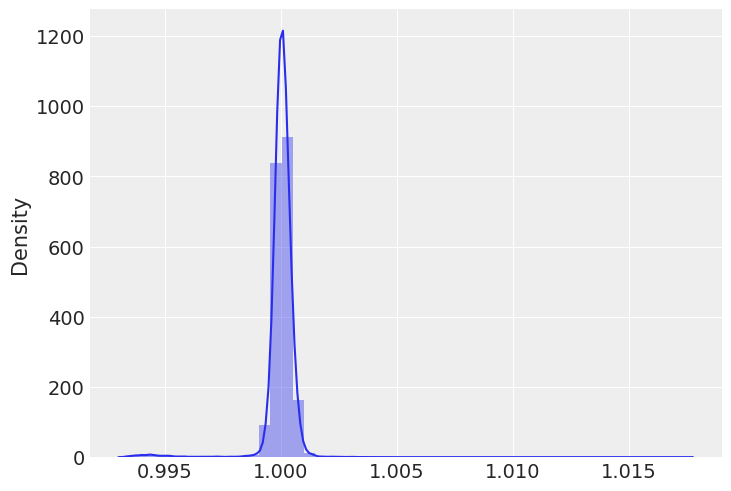

In [419]:
#Distribution of flux
sns.distplot(flux_arr)

Both flux seems to have a very tight 'tailedness'. We can quantify this by looking at the kurtosis of the distrbution. 

In [420]:
print(f"""
flux kurtosis : {scipy.stats.kurtosis(flux_arr)} 
"""
)


flux kurtosis : 52.75267825320591 



Both distributions have a kurtosis much larger than 3 which is what it would be for standard normal distrbution, indicating a very thin tailed distrbution. This means that goodness of fit tests that don't heavily weight distribution tails such as chi-squared would be best for evaluation rather than a Kolmogorov-Smirnov test.

<AxesSubplot: ylabel='Density'>

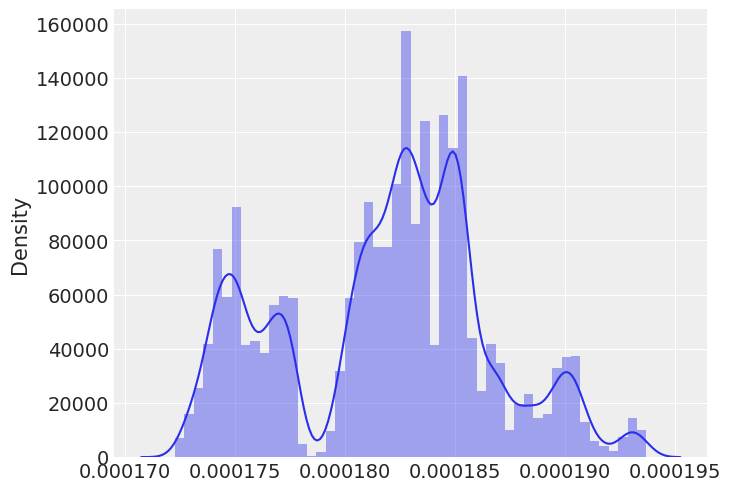

In [421]:
#Look at the distribution plot for the flux error for when we do MCMC simulation of full transit curve
sns.distplot(flux_error_arr)

This flux error term is clearly bimodal. When modelling error term when fitting a light curve in discussion, we will approximate this as the sum of a normal and inverse gamma distribution. 

<h2>Sigma clipping</h2>	


To some extent, the exoplanet orbital behaviour can be a stochastic process. Random noise will to some extent effect chi-squared calculations, 
to circumvent this we impliment sigma clipping, where we remove outliers more than 1 std above the sample mean. 

Text(0, 0.5, 'normalized stellar flux (watts/m^2)')

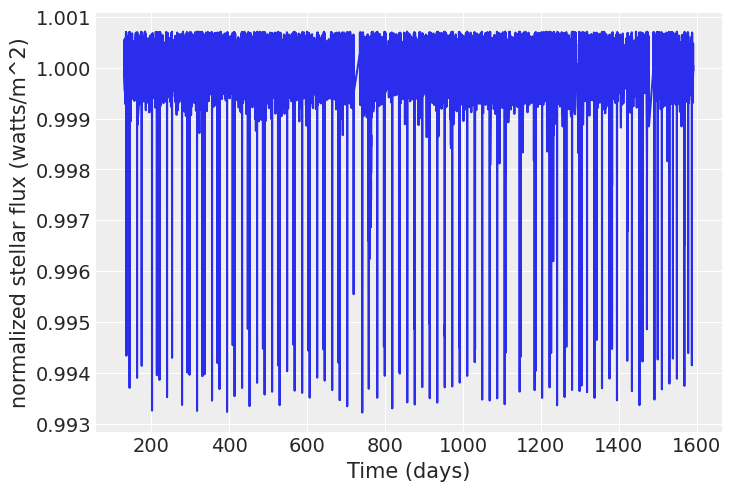

In [422]:
#Perform sigma clipping above the mean to clean the signal 
num_sigma = 1
num_sigma_above_mean = np.mean(sorted_flux) + num_sigma * (np.std(sorted_flux))

flux_value_mask = np.logical_and([x < num_sigma_above_mean for x in sorted_flux],  [x > -1000 for x in sorted_flux])
flux, flux_err, time = sorted_flux[flux_value_mask], sorted_flux_err[flux_value_mask], sorted_time[flux_value_mask]

#Remove single erroneous data point 
plt.plot(time, flux)
plt.xlabel('Time (days)')
plt.ylabel("normalized stellar flux (watts/m^2)")

Next we work to find the number of planets in the system, and the periods of all found exoplanets. 

Although our data is sampled (mostly) equally, we can make use of a Lomb–Scargle periodagram to identify transit periodicity. This works by
finding a 'fourier transform like' description of flux change as a function of period. Large delta function spikes indicate a good liklihood 
of a planet, and it's observed period. 

Text(0, 0.5, 'Power spectral density (PSD)')

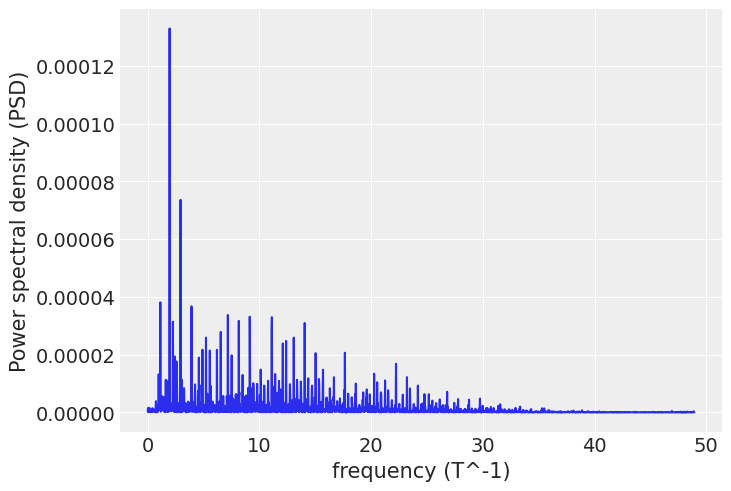

In [423]:
#Find an initial value and calcate the lombscarge of the flux values as a function of:
#The time signal 
#The flux at any given timestep
#The output frequency of the periodagram. 

T = time[-1] - time[0]
dt = time[1] - time[0]
freqs = np.linspace((1/T),(1/dt), 2000)
lomb = scipy.signal.lombscargle(time, flux, freqs, precenter=True)

plt.plot(freqs, lomb)
plt.xlabel('frequency (T^-1)')
plt.ylabel('Power spectral density (PSD)')

This plot seems noisy, this is likely a result of aliasing between planet orbits. We can find a good 
periodosity estimate by using another lombscargle to find the power periodagram as a function of the orbital period.

Text(0, 0.5, 'Power spectral density (PSD)')

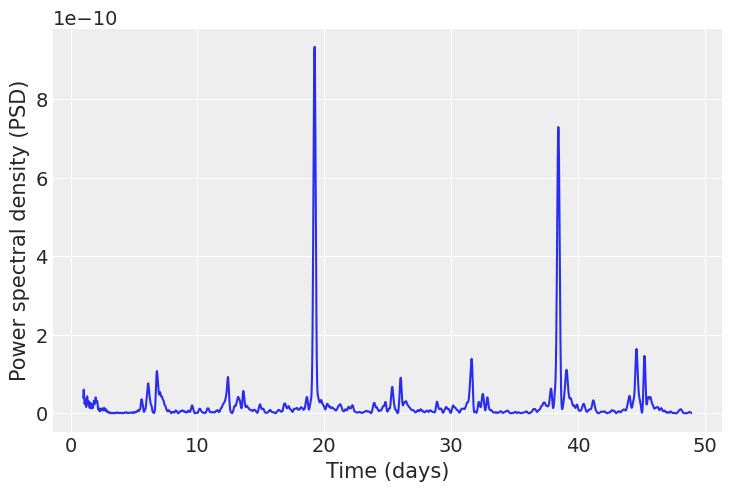

In [424]:
period = np.linspace(1, freqs[-1], 2000)
lomb2 = lombscargle(freqs, lomb, period, precenter = True)

plt.plot(period, lomb2)
plt.xlabel('Time (days)')
plt.ylabel('Power spectral density (PSD)')

In [425]:
periods_found_from_lomb = [19.221, 38.433512752318606]

Here we find two clear spikes corresponding to periods of 19.221 and 38.433 days. We can take these to be the periods for two found 
exoplanets. Next is to try to find estimates for transit depths for both of these found bodies, so that we can find the ratio of the stellar
radius to the planet radius given by 

$$ \frac{\Delta f}{f}  = \frac{R_{p}^{2}}{R_{*}^{2}}$$


where $R_p, R_*$ are the planetary and stellar radii respectively.

<h2>Curve fit for planet with period of around 38 days</h2>	



In [427]:
from utils import model_curve

To find the value for $\Delta f / f$, we take a confirmed transit in our light curve and find the 'depth' of the drop in flux as $\Delta f$ and the sample mean as the flux. We can do this by fitting a low order polynomial to the transiting flux points, and reading out the value for the normalized flux minima. After some analysis, a quartic equasion seems to best model the smoothed parabola of a transit.

To make our transits much clearer for analysis, we fit our polynomial to a 'folded' light curve where flux is plotted against the remainder of the timestep divided by the period, denoted the relative phase. 


    "reduced chi square score for fit number 1 : 4.219621154511472,
    "reduced chi square score for fit number 2 : 3.0772500005893053,
    "reduced chi square score for fit number 3 : 3.270136334889962,
    


    --------------------------------------------------
    average reduced chi square score is 3.5223358299969134 
 


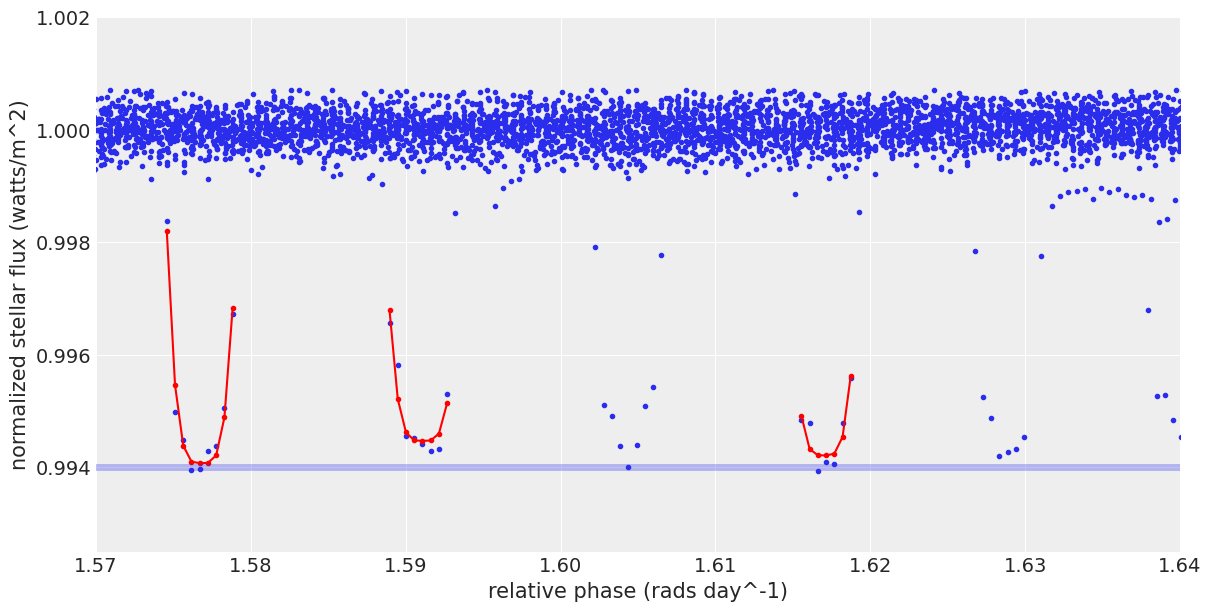

In [428]:
#Fold the light curve to find a folded time, phase, flux and flux error to analyse
time_final, p_final, pflux_final, pflux_error_final = fold_lightcurve(
                                            time.tolist(), 
                                            flux.tolist(), 
                                            flux_err.tolist(), 
                                            periods_found_from_lomb[1]
    )

#Define the masks for the 3 different transits that we want to fit a quartic curve to 
area_mask_1 = (p_final > 1.585) & (p_final < 1.593) & (pflux_final < 0.99902)
area_mask_2 = (p_final > 1.573) & (p_final < 1.58) & (pflux_final < 0.9985)
area_mask_3 = (p_final > 1.614) & (p_final < 1.619) & (pflux_final < 0.998)

#Fit a curve to each of the three transits
popt1, cov1 = curve_fit(model_curve, p_final[area_mask_1], pflux_final[area_mask_1], p0 = [0.994,  1.587, 1.595], sigma = pflux_error_final[area_mask_1])
popt2, cov2 = curve_fit(model_curve, p_final[area_mask_2], pflux_final[area_mask_2], p0 = [0.994,  1.573, 1.581], sigma = pflux_error_final[area_mask_2])
popt3, cov3 = curve_fit(model_curve, p_final[area_mask_3], pflux_final[area_mask_3], p0 = [0.994,  1.609, 1.619], sigma = pflux_error_final[area_mask_3])

#Calculate the goodness of fit for each of the 3 fits 
reduced_chi_1 = chisquared_reduced(p_final[area_mask_1], pflux_final[area_mask_1] , pflux_error_final[area_mask_1], model_curve(p_final[area_mask_1], *popt1))
reduced_chi_2 = chisquared_reduced(p_final[area_mask_1], pflux_final[area_mask_2] , pflux_error_final[area_mask_2], model_curve(p_final[area_mask_2], *popt2))
reduced_chi_3 = chisquared_reduced(p_final[area_mask_1], pflux_final[area_mask_3] , pflux_error_final[area_mask_3], model_curve(p_final[area_mask_3], *popt3))

print(f"""
    "reduced chi square score for fit number 1 : {reduced_chi_1},
    "reduced chi square score for fit number 2 : {reduced_chi_2},
    "reduced chi square score for fit number 3 : {reduced_chi_3},
    \n\n
    --------------------------------------------------
    average reduced chi square score is {np.mean([reduced_chi_1, reduced_chi_2, reduced_chi_3])} 
 """)

#Plot the 3 transits on the folded light curve along with the initial data
plt.figure(figsize = (12, 6))
plot_mask = (p_final < 1.7) & (p_final > 1.5) 
plt.plot(p_final[plot_mask], pflux_final[plot_mask], ls="None", marker="o", ms=3)#ls = 'none')

plt.plot(p_final[area_mask_1], model_curve(p_final[area_mask_1], *popt1), 'r-', marker="o", ms=3)
plt.plot(p_final[area_mask_2], model_curve(p_final[area_mask_2], *popt2), 'r-', marker="o", ms=3)
plt.plot(p_final[area_mask_3], model_curve(p_final[area_mask_3], *popt3), 'r-', marker="o", ms=3)

plt.xlim(1.57, 1.64)
plt.ylim(0.9925, 1.002)
plt.axhline(0.994, alpha=0.3, linewidth=5)
plt.xlabel('relative phase (rads day^-1)')
plt.ylabel("normalized stellar flux (watts/m^2)")
plt.show()

From these found parameters for fitted curves, we can now find the error in the fit and the radius and average transit duration of the exoplanet.

In [536]:
#First parameter is the depth reached, take the average over the 3 fits
depth1, depth2, depth3 = (1 - popt1[0]), 1 - popt2[0], 1 - popt3[0]

#The uncertinity in the depth reached from the fitted model is the first element of the diag of the covariance matrix of the curve fit
#We can find the 1 sigma errors in the fit by taking root of the found variances. 
uncertinty_depth_1, uncertinty_depth_2, uncertinty_depth_3 = np.sqrt(np.diag(cov1)[0]), np.sqrt(np.diag(cov2)[0]), np.sqrt(np.diag(cov3)[0])

#Find the average of the depth and the uncertinty in this. 
average_depth = np.mean([depth1, depth2, depth3])
average_depth_err = np.mean([uncertinty_depth_1, uncertinty_depth_2, uncertinty_depth_3])

stellar_radius = 1 #Given to be one stellar radius pm 2% hence we will multiply final err 1.02 
radius_ratio = np.sqrt(average_depth / np.mean(flux))
radius_ratio_err = np.sqrt(average_depth_err / np.mean(flux))

print(f"radius of the planet in stellar radii : {stellar_radius * radius_ratio} +- {(stellar_radius * radius_ratio_err)*1.02}")
print(f"radius of the planet in earth radii : {109.1 * stellar_radius * radius_ratio} +- {(109.1 * stellar_radius * radius_ratio_err)*1.02}")
print("\n")



transit_length1, transit_length2, transit_length3 = (popt1[2] - popt1[1]) * 24 * periods_found_from_lomb[1], (popt2[2] - popt2[1]) * 24 * periods_found_from_lomb[1], (popt3[2] - popt3[1]) * 24 * periods_found_from_lomb[1]
cov1_depth, cov2_depth, cov3_depth = np.sqrt(np.diag(cov1)), np.sqrt(np.diag(cov2)), np.sqrt(np.diag(cov3))
transit1_duration_err , transit2_duration_err, transit3_duration_err = (cov1_depth[2] - cov1_depth[1]), (cov2_depth[2] - cov2_depth[1]), (cov3_depth[2] - cov3_depth[1])


transit_duration_avg = np.average([transit_length1, transit_length2, transit_length3])
print(f"transit duration: {round(transit_duration_avg, 5)} +- {np.average([transit1_duration_err, transit2_duration_err, transit3_duration_err])} hours")

radius of the planet in stellar radii : 0.07584182898830628 +- 0.011995559445529554
radius of the planet in earth radii : 8.274343542624216 +- 1.3087155355072742


transit duration: 4.65987 +- 2.8073936740421258e-05 hours


This reduced chi squared corresponds to a p value of approximately 0.3. This is not enough for to reject the null hypothesis that our curve is uncorrelated to the data. However, we will call this acceptable because as a result of insufficient signal to noise, we have only have around a dozen points over the course of the transit. 

As a result of small sample size, the chi squared statistic is a poor approximation of goodness of fit as the binomial counts do not accurately approximate a normal distribution. We will therefore take these fit's to be acceptably good as they visually approximate the transit depth, the parameter of interest.

<h2>Curve fit for planet with period of around 19 days</h2>	


For the planet with the smaller period of 19 days, we will only do one fit and chi square calculation. This is because this planet will be our case 
study for habitability analysis, and thus we will later be fitting some much more complex models of transit. 


    period : 19.223274881162116,
    transit guess : 145.7930129692552,
    depth_guess : 0.0021666865475383308
    


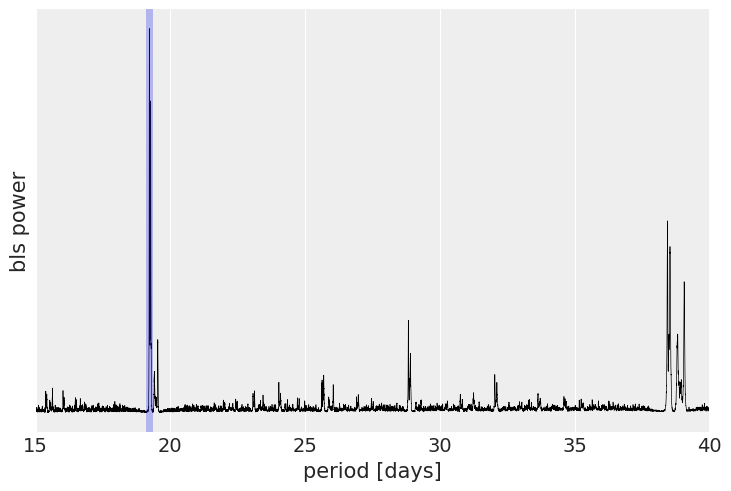

In [430]:
#Find the period, transit and peak guesses using a box least squares estimator for greater accuracy
pg = xo.estimators.bls_estimator(time, flux, flux_err, min_period=15, max_period=40)

peak = pg["peak_info"]
period_guess = peak["period"]
t0_guess = peak["transit_time"]
depth_guess = peak["depth"]

print(f"""
    period : {period_guess},
    transit guess : {t0_guess},
    depth_guess : {depth_guess}
    """
)

plt.plot(pg["bls"].period, pg["bls"].power, "k", linewidth=0.5)
plt.axvline(period_guess, alpha=0.3, linewidth=5)
plt.xlabel("period [days]")
plt.ylabel("bls power")
plt.yticks([])
_ = plt.xlim(pg["bls"].period.min(), pg["bls"].period.max())

reduced chi for plot : 64.35140983682005


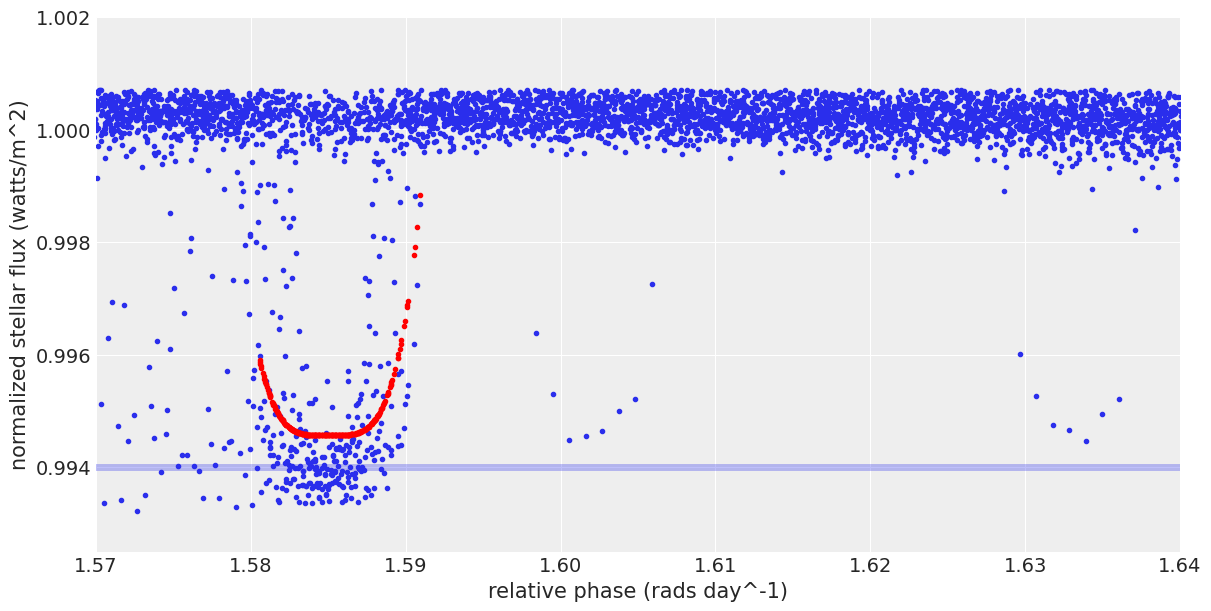

In [431]:
time_final, p_final, pflux_final, pflux_error_final = fold_lightcurve(
                                            time.tolist(), 
                                            flux.tolist(), 
                                            flux_err.tolist(), 
                                            period_guess
    )
#Define masks to fit the transit curve to, and a second for nice visualisation 
area_mask = (p_final > 1.5805) & (p_final < 1.593) & (pflux_final < 0.9995)
plot_mask = (p_final < 1.7) & (p_final > 1.5) 

#Fit the curve
popt4, cov4 = curve_fit(model_curve, p_final[area_mask], pflux_final[area_mask], p0 = [0.994, 1.58, 1.593])

reduced_chi_4 = chisquared_reduced(p_final[area_mask], pflux_final[area_mask] , pflux_error_final[area_mask], model_curve(p_final[area_mask], *popt4))
print(f"reduced chi for plot : {reduced_chi_4}")

#Draw the figure 
plt.figure(figsize = (12, 6))
plt.plot(p_final[plot_mask], pflux_final[plot_mask], ls="None", marker="o", ms=3)#ls = 'none')
plt.plot(p_final[area_mask], model_curve(p_final[area_mask], *popt4), 'r',ls="None", marker="o", ms=3)

plt.xlim(1.57, 1.64)
plt.ylim(0.9925, 1.002)

plt.axhline(0.994, alpha=0.3, linewidth=5)
plt.xlabel('relative phase (rads day^-1)')
plt.ylabel("normalized stellar flux (watts/m^2)")

plt.show()

Following the same method above, we can find the radius of the second planet in stellar radii.

In [432]:
#First parameter is the depth reached,
depth4 = 1-popt4[0]

#The uncertinity in the depth reached from the fitted model is the first element of the diag of the covariance matrix of the curve fit
uncertinty_depth_4 = np.sqrt(np.diag(cov4)[0])

stellar_radius = 1 #Given to be one stellar radius pm 2% hence we will multiply final err 1.02 
radius_ratio = np.sqrt(depth4 / np.mean(flux))
radius_ratio_err = np.sqrt(uncertinty_depth_4 / np.mean(flux))

print(f"radius of the planet in stellar radii : {stellar_radius * radius_ratio} +- {(stellar_radius * radius_ratio_err)*1.02}")
print(f"radius of the planet in earth radii : {109.1 * stellar_radius * radius_ratio} +- {(109.1 * stellar_radius * radius_ratio_err)*1.02}")

radius of the planet in stellar radii : 0.07372293292053463 +- 0.010179591829656998
radius of the planet in earth radii : 8.043171981630326 +- 1.1105934686155785


The implications of the found radius will be analysed in the relevent section. However, these simple curve fits do not yield 
many important parameters that we need for habitability analysis. More complex models are needed to account for orbital 
eccentricity, limb darkening in the host star or the impact parameter of the orbit. 

This extra modelling will be carried out in the discussion to further ascertain the suitability of the exoplanet with a period of 19 days to 
host life. 

### 3. Discussion

$\bullet$ present comparison of your results with data, including statistical analyis and clear figures. 

$\bullet$ limit yourself in the presentation of results, focus on fewer results that are described well, rather than presenting many figures without clear context

$\bullet$ Include a short (~ 200 word) description of a follow-up observations that would address an open question in your report.


<div class="alert alert-block alert-danger">
<b>Word limit: 2000 words</b>

For habitability analysis, there is a multitude of factors that drive how suitable a planet is for supporting life. 

An influential factor for an exoplanet's habitability is the presence of liquid water on its surface. Life on earth all shares liquid water as its common ecological requirement. As a result, there is an implied constraint on the atmospheric temperature of the exoplanet to sustain complex ecosystems. 

From this, we can infer orbital constraints for habitability, for a given stellar luminosity, there exists a range of orbital semi-major axes that will result in a suitable exoplanet surface temperature that bears liquid water. This is commonly coined the 'goldilocks zone' for exoplanet orbit. Exoplanets outside this bound can be subject to levels of X-ray and ultraviolet (UV) radiation hundreds of thousands of times more intense than what Earth receives from the Sun.

 This zones width is also impacted by orbital eccentricity. As detailed in Emeline et Al. (2016), for highly elliptical exoplanet paths through time, there is a large difference in atmospheric temperature at the closest approach of the host star versus the furthest away. This would mean at some points through orbit water on the exoplanet boils, and at others, it freezes. This is not conducive to exoplanet habitability.

A good approximation from Bolmont et Al. (2016) for the presence of liquid water on an exoplanet surface water is the mean-field approximation: if the average stellar flux received over the course of a planet's orbit is near the earth value of 1366 (Watts/m^2), it is likely to bear surface liquid water. As shown, this holds best for orbital eccentricities (e < 0.7). It also assumes an atmospheric composition not dissimilar from that of earth.

A planet with a semi-major axis value of a and orbital eccentricity e over the course of a full orbit will recieve an average stellar flux F of

$$ F = \frac{L_{*}}{4 \pi a \sqrt{1 - e^{2}}}$$

where $L_{*}$ is the luminosity of the host star. 


Another factor for exoplanet habitability findable by transit analysis is planetary mass. Williams and Kasting (1997) provides a lower bound by looking at habitable moons- there exists a minimum planetary mass with which the body can sustain an atmosphere. Assuming an earthlike atmosphere and then analyzing the escape velocity for hot atmospheric gasses Williams and Kasting (1997) finds this to be approximately 0.12 earth masses to allow for the atmosphere to exist for 4.5 billion years- the age of the earth. However, for large exoplanet masses, there is a problem posed by excessively strong gravitational fields. Polijak et Al. (2018) modelled the physics of human locomotion, concluding that exoplanet habitability for humans is possible for masses less than four times that of earth. 

In [556]:
paper 5 https://arxiv.org/abs/1503.07020

SyntaxError: invalid syntax (760255786.py, line 1)

Finding accurate values for the semi-major axis, eccentricity, and exoplanet mass requires accurate modeling of the transit depth, duration, and other factors along with a rigorous consideration of systematic uncertainty. 

The shape of a transiting light curve is impacted in part by stellar limb darkening: the host star's luminosity in the above analysis was assumed to be of uniform intensity. In reality, there exists an optical effect where the edges of a star appear dimmer than its centre. Espinoza and Jordán (2015)
 found incorrect parameterization of this phenomenon can impact the found radius ratio of the exoplanet to its host star by up to 3 percent. In addition. 

The depth of transit, and thus the radii ratio can also be affected by 'grazing' transits where not all of the exoplanet is occluding its host star. Transit can be classified as grazing if for a given impact parameter b


$$ b + \frac{R_{planet}}{R_{*}} > 1 $$

Grazing transits lead to understimation of transit depth, and thus the radius of the exoplanet. 

To derive rigorous estimates for the uncertainty in not both the output and our model parameters, we will use bayesian statistics to model orbital periodicity and normalized stellar flux as a function of time and transit duration. To do this, we define a series of 'priors' for each modeling parameter, given a presupposed understanding of the distribution of their values. These correspond to the likelihood of the data distribution given the model parameters. From this, using Bayes's theorem 

$$p(model | data) = \frac{p(data | model) * p(model)}{p(data)}$$

We can compute a series of 'posterior' distributions for our model parameters given the data distribution. In practice, our posterior probability density function we find is highly dimensional and not easily expressed in closed form. To circumvent this, we make use of 
Monte-Carlo integration to randomly sample these high dimensional posterior distributions. We can ensure the probabilistic dependence between samples by doing this integrad using Markov chains of length approaching infinity. This is known in the literature as Markov Chain Monte-Carlo (MCMC). 



We can fit this bayesian model of the transit to extract posterior distributions for the internal parameters and observables. We fit a keplerian orbit of stationary transit period; an uninformative uniform prior for quadratic stellar limb curve darkening; an uninformative uniform prior for the orbital impact parameter $b$. We use more informed priors for the first transit, period, and depth by using values found with a box least squares periodogram which models transits as a periodic upside-down  top hat with parameters fitted by minimizing log-likelihood over the transit duration

<h2>Light curve preparation</h2>	


 As found from the lombscargle-based periodogram analysis to find the number of system exoplanets, as a result of one planet's period being nearly exactly twice the other there is significant transit aliasing in the light curve. We can circumvent this by using our estimate of the period and only keeping data points within one-quarter of a day of transit.

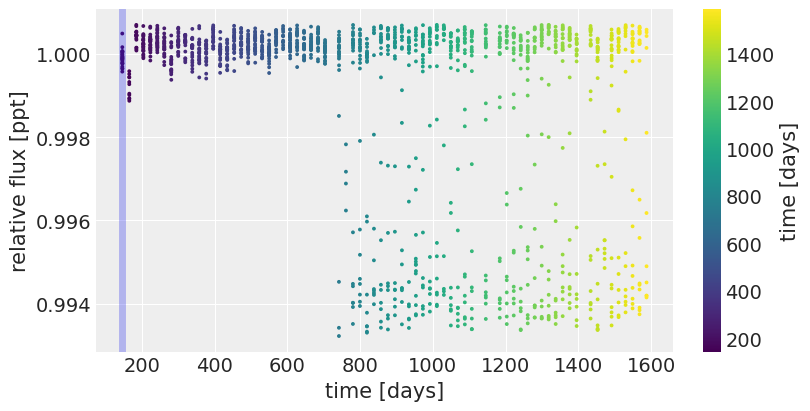

In [433]:
#Take only the data samples within 0.25 days of a transit 
transit_mask = (
    np.abs(
        (time - t0_guess + 0.5 * period_guess) % period_guess - 0.5 * period_guess
    )
    < 0.25
)
#Data cleaning, ensure that all are float64 arrays before modelling
x = np.ascontiguousarray(time[transit_mask])
y = np.ascontiguousarray(flux[transit_mask])
yerr = np.ascontiguousarray(flux_err[transit_mask])

x_fold = (
    x - t0_guess + 0.5 * period_guess
) % period_guess - 0.5 * period_guess


#Show the data that is being fitted to
plt.figure(figsize=(8, 4))
plt.scatter(x, y, c=x, s=3)
plt.axvline(145.7930129692552, alpha=0.3, linewidth=5) # t0 guess 
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")


We will visualize what the 'average transit' for our planet looks like by plotting a fold of its lightcurve.

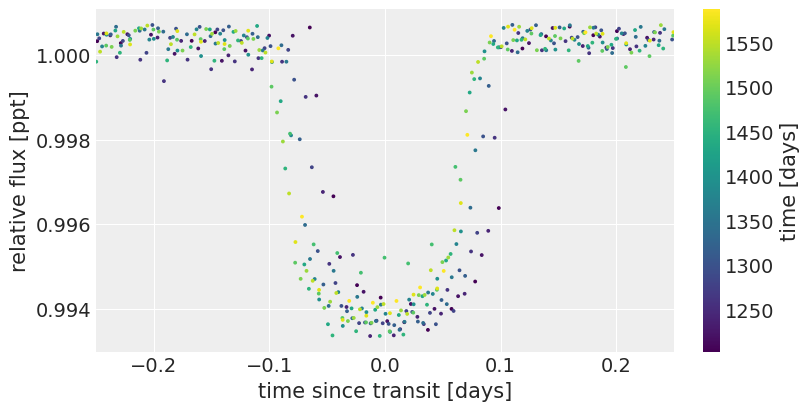

In [493]:
#Plot a lightcurve fold to visualize the 'average' transit for this given period
plt.figure(figsize=(8, 4))
plt.scatter(x_fold, y, c=x, s=3)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
_ = plt.xlim(-0.25, 0.25)

By taking only transits within one-quarter of a day of our found period, we have lost our transits for all flux data before 800 days. Additionally, looking at our folded light curve for all flux data before 1200 days we still see noise as a result of aliasing. To account for this, we will fit our model to only the 400 days of data. This still leaves over a dozen transits for analysis, making any downstream goodness of fit calculations with chi-squared still fine.

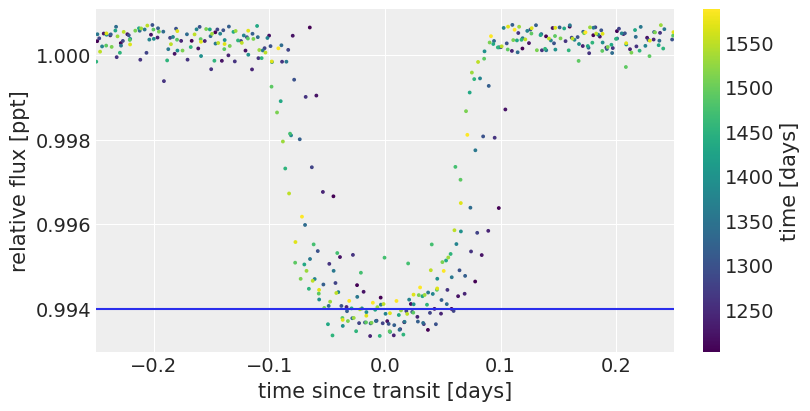

In [492]:
#Mask the time array to remove all flux values for before 1000 days into recording
X_mask_alias = [x > 1200]
x = x[X_mask_alias]
x_fold = x_fold[X_mask_alias]
y = y[X_mask_alias]
yerr = yerr[X_mask_alias]

#Plot the resulting folded light curve, it will look much less noisy. 
plt.figure(figsize=(8, 4))
plt.scatter(x_fold, y, c=x, s=3)
plt.axhline(0.994)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
_ = plt.xlim(-0.25, 0.25)

<h2>Bayesian fitting</h2>	


Next, we fit our model to the time series of stellar flux and its respective error. Flux error is somewhat a stochastic process, and thus would be well characterized by a gaussian process, but in the name of fast model convergence, the flux error prior will be the bimodal distribution found in the exploratory data analysis. 

The model parameters are optimized to find the maximum a posteriori, maximizing the posterior $P(model | data)$

In [436]:
import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

depth_guess = 1 - 0.994
with pm.Model() as model_reduced:
    
    # Stellar parameters
    mean = pm.Normal("flux_mean", mu=1.0006, sigma=0.001)
    u = xo.QuadLimbDark("limbdark")
    star_params = [mean, u]

    # Planet parameters
    log_ror = pm.Normal(
        "log_radius_ratio", mu=0.5 * np.log(depth_guess * 1e-3), sigma=0.1
    )
    ror = pm.Deterministic("radius_ratio", tt.exp(log_ror))

    #Error parameters
    err_inverse_gamma = pm.InverseGamma("err_gamma", alpha=3.0, beta=1 * np.median(yerr))
    err_gauss = pm.Normal("err_gauss", mu=0, sigma=2 * np.std(yerr))
    err = pm.Deterministic('err_total', err_inverse_gamma + err_gauss)

    # Orbital parameters
    log_period = pm.Normal("log_period", mu=np.log(period_guess), sigma=0.05)
    period = pm.Deterministic("period", tt.exp(log_period))
    t0 = pm.Normal("t0", mu=t0_guess, sigma=1.0)
    log_dur = pm.Normal("log_duration", mu=np.log(0.17), sigma=0.05)
    dur = pm.Deterministic("duration", tt.exp(log_dur))
    
    b = xo.distributions.ImpactParameter("impact_parameter", ror=ror,)

    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=period, 
        duration=dur, 
        t0=t0, 
        b=b,
        )

    # Stellar density that will be used to find implied eccentricity
    pm.Deterministic("stellar_density", orbit.rho_star)

    #Mean transit model 
    star = xo.LimbDarkLightCurve(u)
    lc_model = mean + 1e3 * tt.sum(
        star.get_light_curve(orbit=orbit, r=ror, t=x), axis=-1
    )


    # Double check that everything looks good - we shouldn't see any NaNs!
    print(model_reduced.check_test_point())

    # Optimize the model
    map_soln = model_reduced.test_point
    map_soln = pmx.optimize(map_soln, [ror, b, dur])
    map_soln = pmx.optimize(map_soln, err)
    map_soln = pmx.optimize(map_soln, star_params)
    map_soln = pmx.optimize(map_soln)

flux_mean                     5.99
limbdark_quadlimbdark__      -2.77
log_radius_ratio              1.38
err_gamma_log__              -0.53
err_gauss                    10.59
log_period                    2.08
t0                           -0.92
log_duration                  2.08
impact_parameter_impact__    -1.39
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [log_duration, impact_parameter, log_radius_ratio]


message: Optimization terminated successfully.
logp: 16.504366879704282 -> 16.504372850435878


optimizing logp for variables: [err_gamma, err_gauss]


message: Optimization terminated successfully.
logp: 16.504372850435878 -> 16.64132663307243


optimizing logp for variables: [limbdark, flux_mean]


message: Optimization terminated successfully.
logp: 16.64132663307243 -> 16.64132663307243


optimizing logp for variables: [impact_parameter, log_duration, t0, log_period, err_gauss, err_gamma, log_radius_ratio, limbdark, flux_mean]


message: Optimization terminated successfully.
logp: 16.64132663307243 -> 16.64132663307243


Given this optimized light curve transit model, we will use it to compute predictions for the stellar flux as a function of time.

In [437]:
with model_reduced:
    lc_pred = pmx.eval_in_model(lc_model, map_soln)

We will also use MCMC to draw a sample from the posterior distribution of all of our stellar transit model parameters. We can then analyze these to find the predicted means and standard deviations in our predictions, and any model covariances.

In [438]:
with model_reduced:
    trace_small = pm.sample(
        tune=4000,
        draws=4000,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=2,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[261136679, 261136680],
        init="adapt_full",
    )
import pickle 
with open("trace.pkl", "wb") as f: 
    pickle.dump(trace_small, f)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
INFO:pymc3:Initializing NUTS using adapt_full...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [impact_parameter, log_duration, t0, log_period, err_gauss, err_gamma, log_radius_ratio, limbdark, flux_mean]
INFO:pymc3:NUTS: [impact_parameter, log_duration, t0, log_period, err_gauss, err_gamma, log_radius_ratio, limbdark, flux_mean]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.
INFO:pymc3:Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.


In [439]:
#Compute a summary of the posterior samples for each of the model parameters
with model_reduced:
    sample_summary = az.summary(trace_small)

#stellar density has sample cases where due to not finite samples it is NAN, this will be cleaned up manually later.
#Show only mean, std and the hdi's. Other stuff is interesting, but not pertinent to this report.
sample_summary[["mean","sd","hdi_3%","hdi_97%"]]

arviz - WARNING - Array contains NaN-value.


mean     sd   hdi_3%  hdi_97%
flux_mean           1.001  0.001    0.999    1.003
log_radius_ratio   -6.013  0.100   -6.208   -5.835
err_gauss           0.000  0.000   -0.000    0.000
log_period          2.955  0.050    2.857    3.046
t0                145.795  1.008  143.905  147.685
log_duration       -1.772  0.050   -1.865   -1.678
limbdark[0]         0.670  0.478    0.000    1.527
limbdark[1]        -0.005  0.412   -0.757    0.762
radius_ratio        0.002  0.000    0.002    0.003
err_gamma           0.000  0.000    0.000    0.000
err_total           0.000  0.000    0.000    0.000
period             19.227  0.970   17.414   21.021
duration            0.170  0.009    0.155    0.187
impact_parameter    0.507  0.290    0.041    0.979
stellar_density       NaN    NaN    0.085      NaN

In the appendix, traceplots and corner plot of all parameters are generated to ensure that burn in has completed and the chains aree to the posterior density estimates. Both of these are true.

Because flux and time are continuous variables, to analyze the goodness of our bayesian fit in a frequentist way we will mainly rely on the Kolmogorov–Smirnov test. We compute the depth as the bottom of the fitted transit plotted below.

K-S test p value : 1.675176843825009e-52
0.007102648353796148


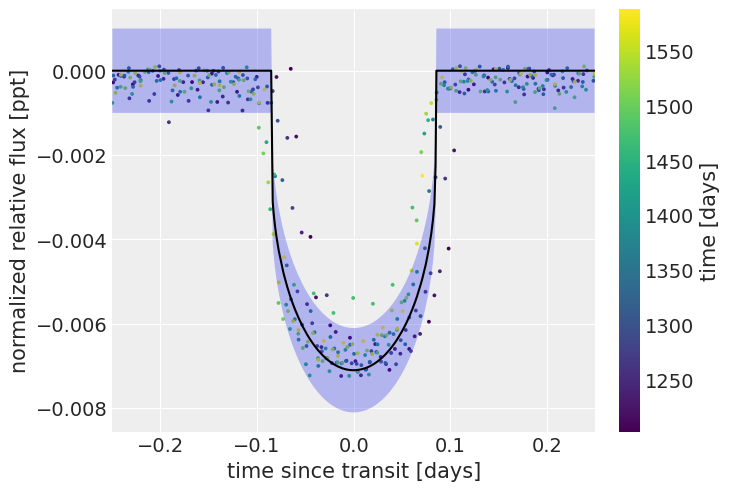

In [440]:
inds = np.argsort(x_fold)
reduced_chi = chisquared_reduced(x_fold, (y  - map_soln["flux_mean"]),sample_summary['sd']['flux_mean'], (lc_pred[inds] - map_soln["flux_mean"]))
k_s_score = scipy.stats.kstest(y  - map_soln["flux_mean"], lc_pred[inds] - map_soln["flux_mean"])
print(f"K-S test p value : {k_s_score.pvalue}")

print(map_soln["flux_mean"] - min(lc_pred[inds]))
plt.scatter(x_fold, y  - map_soln["flux_mean"], c=x, s=3)
plt.plot(x_fold[inds], lc_pred[inds] - map_soln["flux_mean"], "k")
plt.fill_between(x_fold[inds],
            y1 = lc_pred[inds] - map_soln["flux_mean"] - sample_summary['sd']['flux_mean'], 
            y2 = lc_pred[inds] - map_soln["flux_mean"] + sample_summary['sd']['flux_mean'],
            alpha = 0.3
    )
plt.xlabel("time since transit [days]")
plt.ylabel("normalized relative flux [ppt]")
plt.colorbar(label="time [days]")
_ = plt.xlim(-0.25, 0.25)

The p-value and visual inspection of the fit seem very strong.

<h2>Finding the radius of exoplanet from bayesian fit </h2>	

As for the frequentist light curve modeling, we can compute the radius ratio, and by extension our exoplanet radius. This and all other 
parameters in terms of 1 sigma uncertainty.

In [550]:
depth_bayesian = np.mean(lc_pred[inds]) - min(lc_pred[inds])

#The uncertinity in the depth reached from the fitted model is the first element of the diag of the covariance matrix of the curve fit
bayesian_1_sd = sample_summary['sd']['flux_mean']

stellar_radius = 1 #Given to be one stellar radius pm 2% hence we will multiply final err 1.02 
radius_ratio = np.sqrt(depth_bayesian / np.mean(lc_pred[inds]))
radius_ratio_err = np.sqrt(bayesian_1_sd / np.mean(flux))

print(f"radius of the planet in stellar radii : {stellar_radius * radius_ratio} +- {(stellar_radius * radius_ratio_err)*1.02}")
print(f"radius of the planet in earth radii : {109.1 * stellar_radius * radius_ratio} +- {(109.1 * stellar_radius * radius_ratio_err)*1.02}")

print(f"transit duration : {sample_summary['mean']['duration'] * 24} +- {round(sample_summary['sd']['duration'] * 24, 3)} hours")

radius of the planet in stellar radii : 0.06861635885402369 +- 0.032255782961740746
radius of the planet in earth radii : 7.486044750973984 +- 3.519105921125915
transit duration : 4.08 +- 0.216 hours


<h2>Analyzing the orbital semi-major axis and planetary mass</h2>	


We can compute the semi-major axis of orbit using Kepler's third law, which relates the semi-major axis of the orbit $a$ to its period $T$ by

$$ T^2 = \frac{4 \pi ^2}{GM} a^3$$

$$\frac{T^2  GM}{4 \pi ^2} = a^3$$

where $G$ is the gravitational constant and $M$ is the stellar mass.

In [442]:
#Define constants
stellar_mass = 1.98847e30
G = 6.67430e-11
au =  1.495978707e11

#Convert orbital period to SI 
orbit_period_mean = sample_summary['mean']['period'] * 24 * 3600
orbit_period_std = sample_summary['sd']['period']* 24 * 3600

#Compute the mean and 1 std uncertinity for the semi major axis given stellar mass 
semi_major_axis_mean = np.cbrt((orbit_period_mean**2 * G* stellar_mass) / (4 * np.pi**2)) / au 
semi_major_axis_std = np.cbrt((orbit_period_std**2 * G* stellar_mass) / (4 * np.pi**2)) * 1.02 / au #Multiply by 1.02 to account for 2% uncertinity in Stellar mass error.

print(f"semi-major axis : {round(semi_major_axis_mean,4)}+-{round(semi_major_axis_std, 5)} au       (1 std)")

semi-major axis : 0.1405+-0.01956 au       (1 std)


Yielding a value of roughly 14% of that of earth. To see if this falls within normal bounds for habitable exoplanets, we have downloaded the characteristics of over 35,00 planets and their host stars.
For each of these planets with known eccentricity, semi-major axis, and host star luminosity we have used the mean field approximation for stellar flux from Emeline et Al. (2016) to find the average flux over an exoplanet orbit. 

Candidate habitable planets have been kept with flux averages with the same order of magnitude as earth to account for differences in magnetosphere or atmosphere we cannot ascertain from a transit curve. We will generate a density plot of the planetary mass and radius to consider if our found values are within normal bounds for planets bearing liquid water.

Additionally, planets with mass 250 times greater than that of earth or 20 times earth's radius have been discarded for their respective plots as these values would not bear life as discussed previously.


For the planetary mass, this could be found by analyzing the transit timing variations as shown by Hadden and Lithwick (2017) that can be seen in the unfolded stellar light curve. However, for this characterisation, we will use the given value of 29.1 earth masses.

In [443]:
#Load nasa exoplanet data
df = pd.read_csv(os.getcwd() + "/big_exoplanet_data.csv")

#Use meanfield approximation to find the stellar flux 
df['flux_recieved'] = df.apply(lambda x : find_average_orbital_flux(luminosity = x.st_lum, semimajor = x.pl_orbsmax, eccentricity = x.pl_orbeccen), axis=1)

#Keep only finite values for flux recieved so we can constrain known values for e, a and L. 
df = df[np.isfinite(df['flux_recieved'])]

#Keep only one order mag of earth value 1366
df = df[(df['flux_recieved'] > 1000) & (df['flux_recieved'] < 10000)]

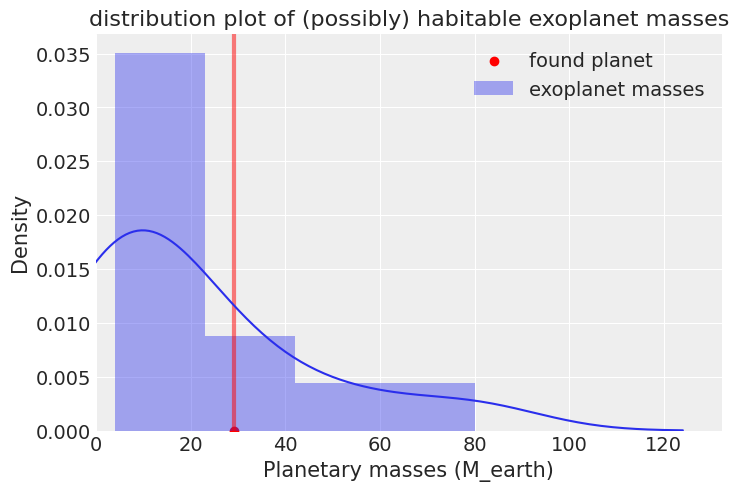

In [458]:
#Find only known planetary masses with mass < 100 earths 
df_mass = df[np.isfinite(df.pl_masse)]
df_mass = df[df.pl_masse < 100]

#Plot graph 
fig, ax = plt.subplots()
plt.axvline(29.1, alpha=0.5, linewidth=3, c = "r")
plt.scatter(29.1, 0, c = "r", label = "found planet")
sns.distplot(df_mass.pl_masse, label = "exoplanet masses")

plt.xlabel("Planetary masses (M_earth)")
plt.title("distribution plot of (possibly) habitable exoplanet masses")
plt.xlim(0)
plt.legend()
plt.show()

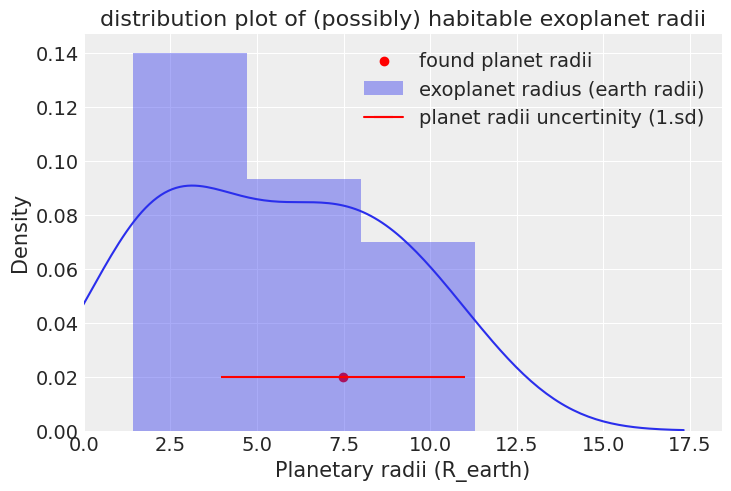

In [459]:
#Find only planets with known radius less than 20 earth radii 
df_radius = df[np.isfinite(df.pl_rade)]
df_radius = df[df.pl_rade < 20]

#Plot graph
fig, ax = plt.subplots()
plt.scatter(109.1 * stellar_radius * radius_ratio, 0.02, c = "r", label = "found planet radii")
plt.errorbar((109.1 * stellar_radius * radius_ratio), 0.02, xerr= ((109.1 * stellar_radius * radius_ratio_err)*1.02),c = "r", alpha = 1, label = "planet radii uncertinity (1.sd)")
sns.distplot(df_radius.pl_rade, label = "exoplanet radius (earth radii)")
plt.xlabel("Planetary radii (R_earth)")
plt.title("distribution plot of (possibly) habitable exoplanet radii")
plt.xlim(0)
plt.legend()
plt.show()

Although no error was given for the planetary mass, we can see that for our planets that can bear liquid water at their centre, both the semi-major axis and mass of our found planet fall cleanly within the distribution.
Additionally, the planetary radii are above the minimum posted by Williams and Kasting (1997) to sustain a gaseous atmosphere, allowing for the possible presence of an oxygen rich atmosphere.
Despite this, however, the exoplanet mass is over five times the limit posed by Polijak et Al. (2018), meaning humans would be unable to move around freely on the planet's surface, making it an unsuitable candidate for habitation. 

<h2>FIND MEAN FIELD FLUX FOR OUR EXOPLANET </h2>	


To find if our exoplanet can have surface liquid water, we need to know its host star luminosity, its orbital eccentricity, and its semi-major axis to compute the average flux received over an orbit.

Since the star is not especially massive, we can compute a lower bound for the average stellar flux by assuming a perfectly eccentric orbit, and then analyze if this is true. The stellar luminosity $L_{*}$ can be found by approximating the host star as a black body and using Stefans Law

$$L_{*} = \sigma T^{4}$$

where $\sigma$ is the Stefan-Boltzmann constant and $T$ is the absolute temprature.

In [468]:
#Define constants 
boltzman_constant =  5.670374419e-8
temp = tmp[0].header['TEFF']    #For our star, the effective temprature is an approximation of the absolute temp which is not exactly known

#Use the absolute temp of our sun to find the stellar luminosity of the host star in terms of our sun. 
stellar_luminosity = (temp/5778)**4
average_flux = find_average_orbital_flux(stellar_luminosity, (semi_major_axis_mean), 0)

print(f"Average flux recieved over orbit : {average_flux} +- {average_flux * (semi_major_axis_std / semi_major_axis_mean)} (W / m^2)")

Average flux recieved over orbit : 69367.54617376716 +- 9660.43410158336 (W / m^2)


An average flux of (69 kW / m^2) is extremely high. This would easily turn any liquid surface water to steam, likely with enough kinetic energy to escape the exoplanet's atmosphere over time. Without a source of liquid water, biodiversity on the exoplanet would be heavily constrained, ultimately making habitability unlikely.

<h2>Future work </h2>	


As discussed, orbital eccentricity plays a large role in the habitability of an exoplanet by making the orbital semi-major axis a function of time. We can make 
educated guesses as to the eccentricity by following the methods in the python package 'exoplanets' case study. 

The authors find quantile estimates for the orbital eccentricity by weighting an uninformative prior of the "G parameter" from Dawson and Johnson (2012) with the implied stellar density from a keplerian orbit model.

This methodology is replicated below.


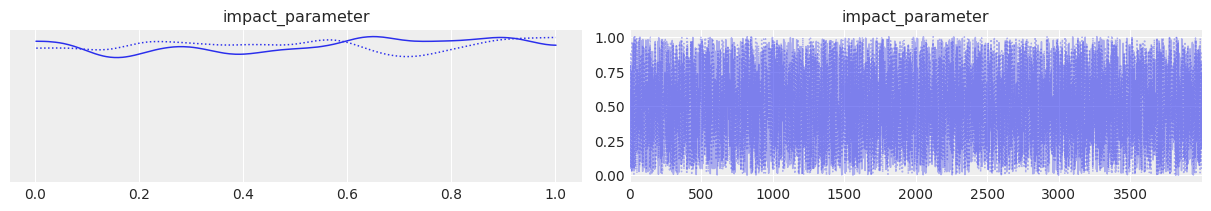

In [489]:
import arviz as az
az.style.use("arviz-darkgrid")

with model_reduced:
    az.plot_trace(trace_small, var_names = "impact_parameter")

The trace plot of the histogram for the two MCMC chains shows visible divergence, to ensure that this can be used confidently we will compute a z score of the two chains to make sure they are drawn from the same constant distribution

In [475]:
#On trace plot chains visably diverge, check the z score to see if chains reasonably drawn from same distribution and can be averaged by finding 
#Z score between two chains 
chain_rho_circ_1 = trace_small.posterior["stellar_density"].to_numpy()[0]
chain_rho_circ_2 = trace_small.posterior["stellar_density"].to_numpy()[1]
mask = np.logical_and(np.isfinite(chain_rho_circ_1), np.isfinite(chain_rho_circ_2))

z_score = np.abs((np.mean(chain_rho_circ_1[mask]) - np.mean(chain_rho_circ_2[mask])) / np.sqrt(np.std(chain_rho_circ_1[mask]**2)-np.std(chain_rho_circ_2[mask])**2))
print(f"z score of chains being sampled from common (stable) posterior distribution: {z_score}")

if z_score < 2: 
    print("we are sufficiently confident that drawn from common distribution, merge chains and carry on!")

z score of chains being sampled from common (stable) posterior distribution: 0.016864347844739086
we are sufficiently confident that drawn from common distribution, merge chains and carry on!


In [485]:
#Merge two chains to find the posterior distributionsample for the stellar density 
rho_circ = np.asarray(trace_small.posterior["stellar_density"]).flatten()

#Apply masking to remove non finite values
rho_mask = np.isfinite(rho_circ)
rho_circ = rho_circ[rho_mask]

#Taken from assumed stellar mass and radius being 1 stellar mass and radius pm 2%
#Density = mass / volume of sphere, uses r^3 and mass once, linear operations yield
# Additive errors so it is 0.02 * 4 for error prop.
tic_rho_star = (1, 0.08)

In [486]:
# Sample eccentricity and omega from their (uninformative) priors
ecc = np.random.uniform(0, 1, len(rho_circ))
omega = np.random.uniform(-np.pi, np.pi, len(rho_circ))
impact = np.asarray(trace_small.posterior["impact_parameter"]).flatten()[rho_mask]

# Compute the "g" parameter from Dawson & Johnson and what true
# density that implies
g = (1 + ecc * np.sin(omega)) / np.sqrt(1 - ecc**2)
rho = rho_circ / g**3

# Re-weight these samples to get weighted posterior samples
log_weights = -0.5 * ((rho - tic_rho_star[0]) / tic_rho_star[1]) ** 2
weights = np.exp(log_weights - np.max(log_weights))

# Estimate the expected posterior quantiles
q = corner.quantile(ecc, [0.16, 0.5, 0.84], weights=weights) # values for quantile taken from Chebyshev's inequality

#Print the the found eccentricity bounds
print(
    "eccentricity = {0:.3f} +{1[1]:.3f} -{1[0]:.3f}".format(q[1], np.diff(q))
)

#Print the found angle of orbit
print(f"""Angle of orbital inclination = \
{round(np.arccos(np.mean(trace_small.posterior['impact_parameter'].to_numpy()) * (0.00465047) / semi_major_axis_mean),3)}\
+-\
{round(np.arccos(np.std(trace_small.posterior['impact_parameter'].to_numpy()) * (0.00465047) / semi_major_axis_std),3)}\
 radians"""
)

eccentricity = 0.321 +0.315 -0.203
Angle of orbital inclination = 1.554+-1.502 radians


This yields a moderate orbital eccentricity $e$ in line with what could be possible for a medium-large exoplanet. This being said, the histogram plot of the impact parameter has not managed to converge in the MCMC simulation beyond a uniform prior. The impact parameter $b$ heavily bounds $e$ in practice, making estimates of $e$ spurious at best.

The degeneracy between $b$, $e$, and the stellar density can be visualized using a corner plot


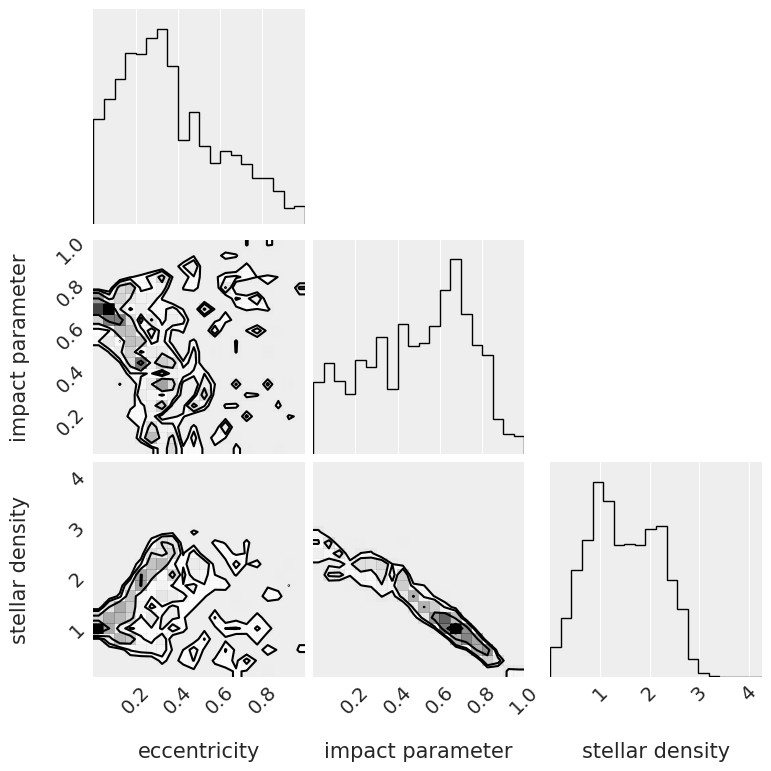

In [490]:
#Make corner plot of eccentricity, impact parameter and stellar density
_ = corner.corner(
    np.vstack((ecc, impact, rho_circ)).T,
    weights=weights,
    plot_datapoints=False,
    labels=["eccentricity", 'impact parameter', "stellar density"],
)

There is clear degeneracy between $b$ and the stellar density. This heavy correlation places a poor upper bound on how well either is parameterized in the model, making the value of $e$ highly innacurate.

To better estimate the orbital eccentricity, estimates of the stellar density could be found using additional data collection. By looking at the emission spectra of the host star, we could make educated guesses as to its composition and use the known stellar radii to compute a more accurate scalar stellar density.

This would allow for a better understanding of the path of the orbit and by extension the exoplanet's surface temperature.

### 4. Summary

$\bullet$ summarize your results. This can be done in text or bullet points.

<div class="alert alert-block alert-danger">
<b>Word limit: 300 words</b>

For planet one, the following parameters were found and extracted

* orbital_period :  38.433512752318606
* Normalized transit_depth :    0.0057517865741609775 
* radius (earth radii):     8.274343542624216 +- 1.3087155355072742
* transit_duration : 4.65987 +- 2.8073936740421258e-05  hours

The semi-major axis was easily computable also, but not found as the habitability analysis was restricted only to planet two. 



For planet two, the following parameters were found by doing MCMC 
Good fits: 
* orbital_period (days):  19.223 +- 0.97
* Normalized transit_depth: 0.0061
* radius (earth radii):  7.486044750973984 +- 3.519105921125915
* transit_duration: 4.08 +- 0.216 hours
* semi-major axis : 0.1405+-0.01956 au       (1 std)
* average recieved flux : 69367.54617376716 +- 9660.43410158336 (W / m^2)

Bad fits:
* eccentricity : 0.321 +0.315 -0.203 (bad fit)
* impact parameter : 0.507 +- 0.290 (bad fit)
* orbital inclination angle:  1.554+-1.502 radians
- stellar density (sun) : 1.41 


In addittion to finding these values, we have conduced a rigerous error analysis for both planets, and set the results for planet two inside a discussion into habitability, finding that planet 2 likely is too hot to have liquid water, has a gravity too intense to allow for humans to walk about, and a likely eccentric orbit. That being said it can support a gaseous atmosphere.

To conclude, it is highly unlikely that planet two is habitable. 

### APPENDIX

1. SAMPLE AND PDF PLOTS

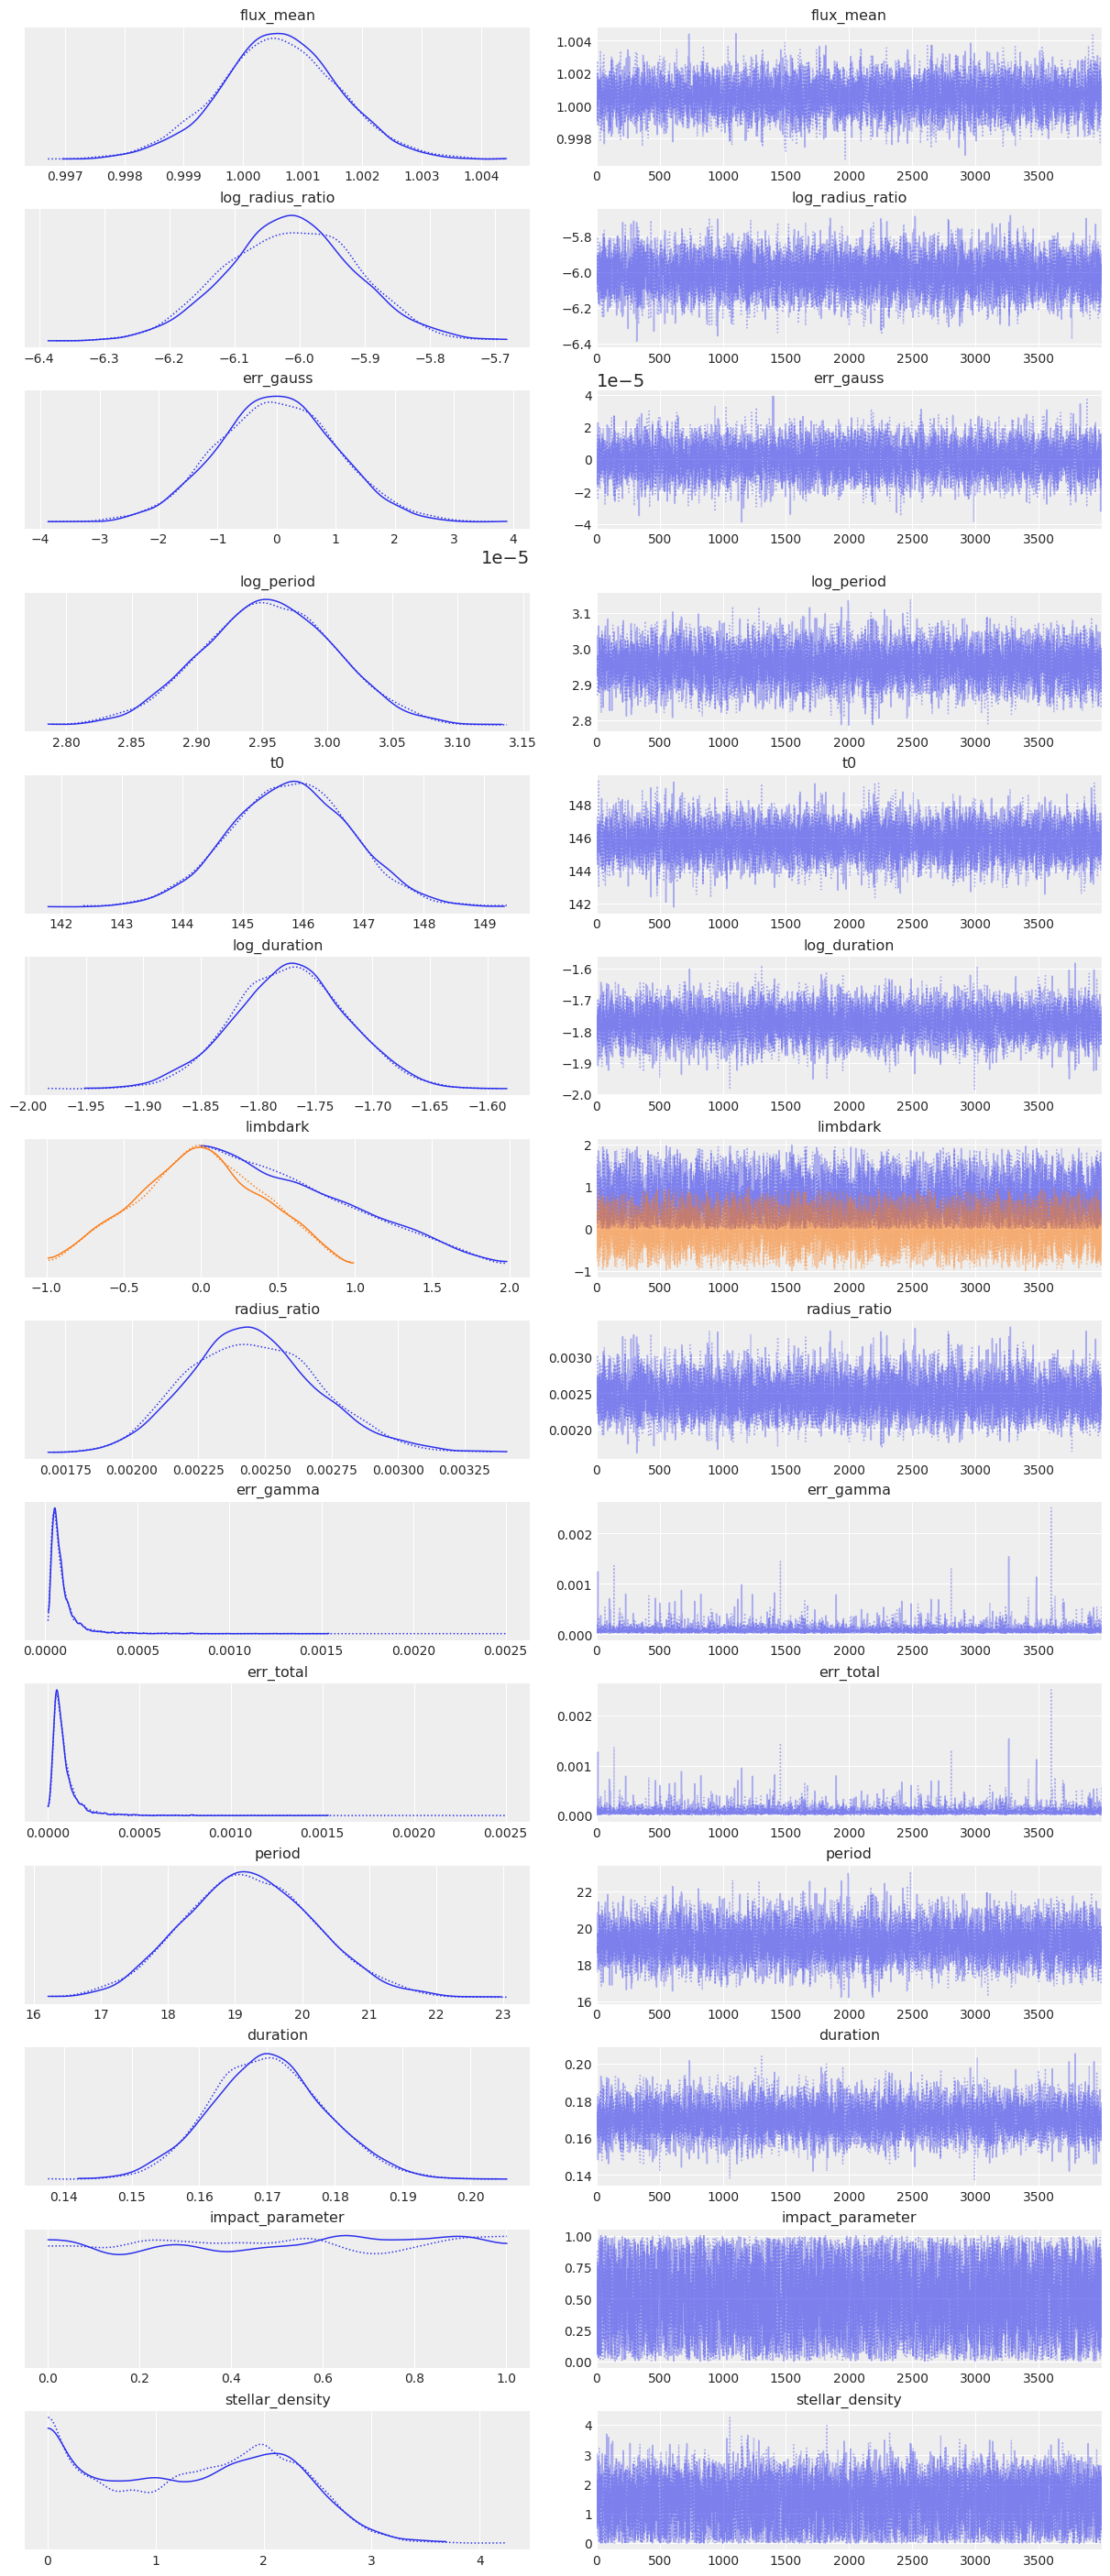

In [456]:
import arviz as az
az.style.use("arviz-darkgrid")

with model_reduced:
    az.plot_trace(trace_small,)

CORNER PLOT OF ALL PARAMS THAT DO NOT HAVE NAN IN CHAIN (stellar density does have one thus is not plotted)

Figure(3070x3070)


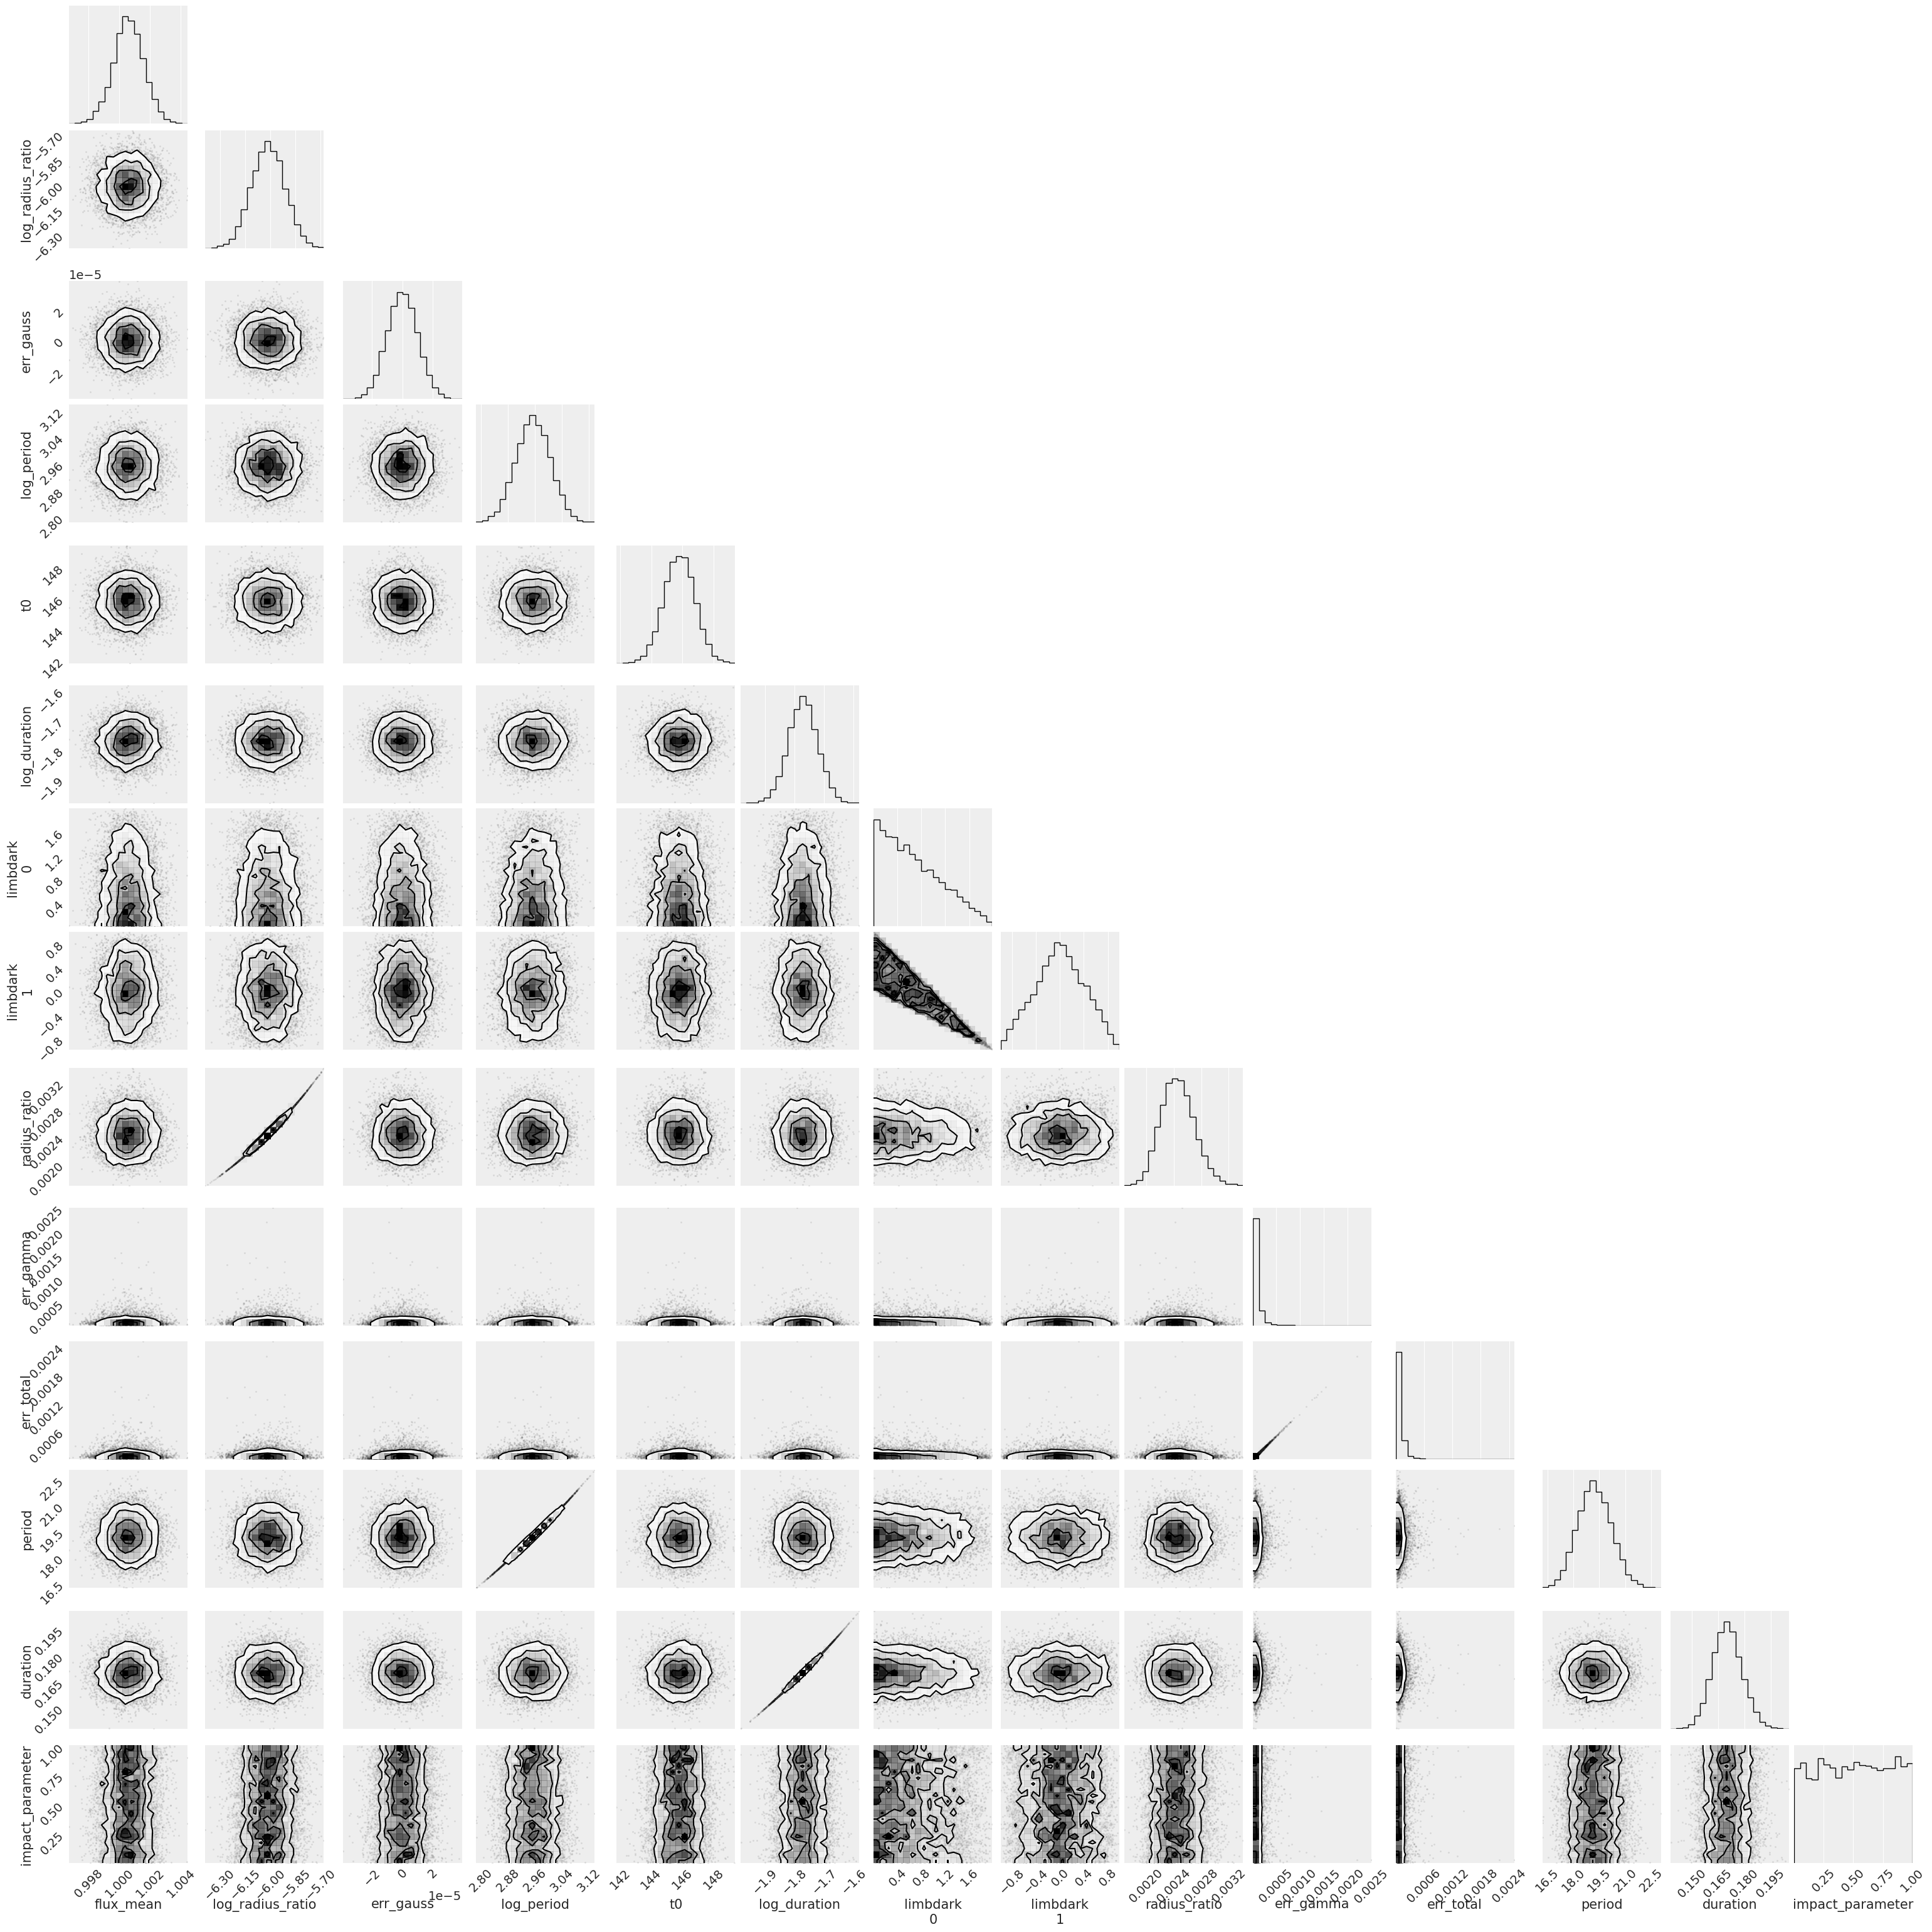

In [457]:
print(corner.corner(trace_small, var_names= list(trace_small.posterior.data_vars.keys())[:-1]))

Figure(970x970)


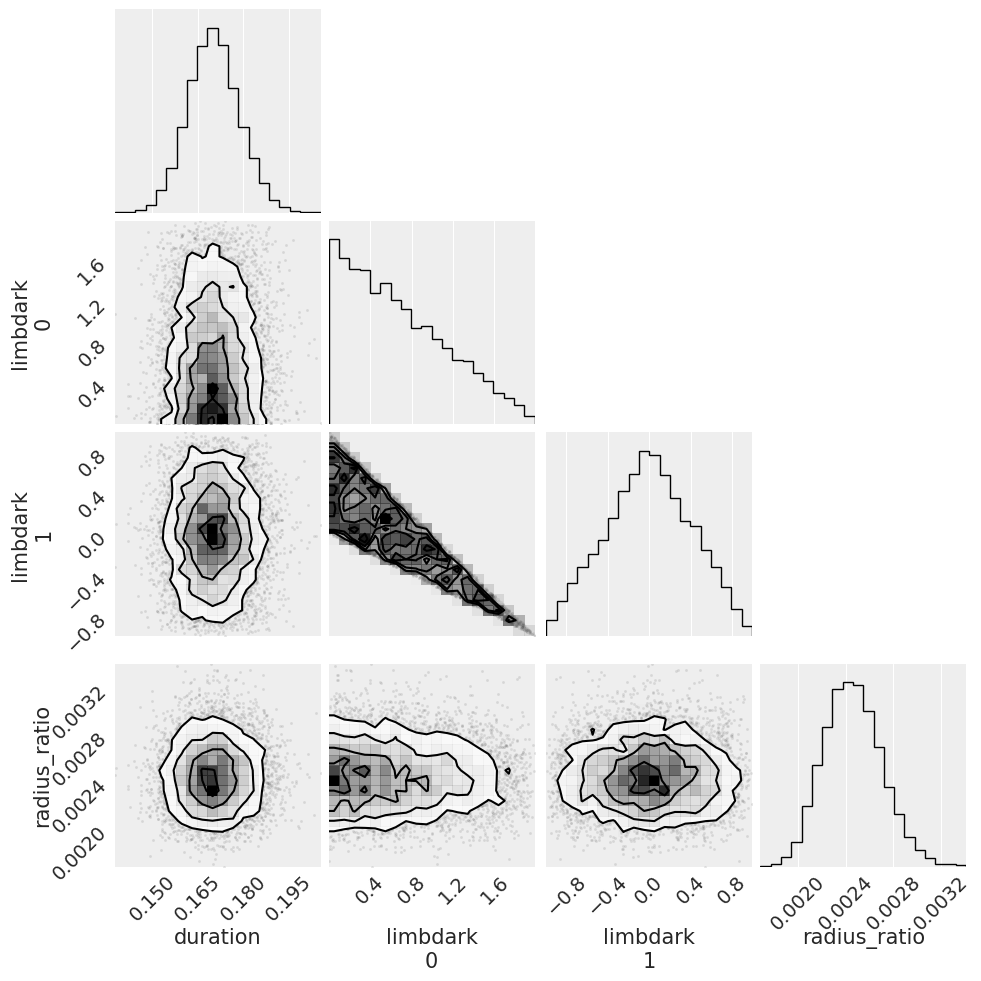

In [491]:
print(corner.corner(trace_small, var_names= ["duration", "limbdark", "radius_ratio"]))

### References:

- Yadev, 2018, 00
- Polijak et Al, 2018, 
- Williams and Kasting, 1997, Nature, 385(6613):234-6
- Hadden and Lithwick, 2017, The Astronomical Journal,15,1
- Espinoza and Jordán, 2015, MNRAS.
- Ricker et Al, 2014, SPIE, 9143, 001
- Dawson and Johnson, 2012, ApJ, 756, 122.
- Bolmont et Al, 2016, A&A, A106

### Acknowledgments

Acknowlegde the use of any software or datasets here.

In [558]:
with model_reduced:
    txt, bib = xo.citations.get_citations_for_model()

print(bib.split("\n\n")[0] + "\n\n...")



@article{exoplanet:joss,
       author = {{Foreman-Mackey}, Daniel and {Luger}, Rodrigo and {Agol}, Eric
                and {Barclay}, Thomas and {Bouma}, Luke G. and {Brandt},
                Timothy D. and {Czekala}, Ian and {David}, Trevor J. and
                {Dong}, Jiayin and {Gilbert}, Emily A. and {Gordon}, Tyler A.
                and {Hedges}, Christina and {Hey}, Daniel R. and {Morris},
                Brett M. and {Price-Whelan}, Adrian M. and {Savel}, Arjun B.},
        title = "{exoplanet: Gradient-based probabilistic inference for
                  exoplanet data \& other astronomical time series}",
      journal = {arXiv e-prints},
         year = 2021,
        month = may,
          eid = {arXiv:2105.01994},
        pages = {arXiv:2105.01994},
archivePrefix = {arXiv},
       eprint = {2105.01994},
 primaryClass = {astro-ph.IM},
       adsurl = {https://ui.adsabs.harvard.edu/abs/2021arXiv210501994F},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System